In [14]:
# DEPENDENCIAS
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import emoji
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter
from langdetect import detect
from deep_translator import GoogleTranslator
import time
import logging
import pandas as pd

# Opciones de visualización de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [15]:
# CARGA DE ARCHIVOS

# URL DATA: Lectura del excel principal de la extracción de datos
ruta_excel = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\data\url_data.xlsx"

try:
    df = pd.read_excel(ruta_excel)
    print("Archivo Excel leído correctamente")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta {ruta_excel}")
    raise
except Exception as e:
    print(f"Error al leer el archivo Excel: {e}")
    raise


Archivo Excel leído correctamente


#### Análisis Descriptivo-Exploratorio y ETL:

##### URL Data

In [16]:
print("\nDimensiones del dataset:", df.shape)


Dimensiones del dataset: (204, 9)


In [17]:
print("\nPrimeras filas:")
print("-----------------")
df.head(3)


Primeras filas:
-----------------


,url_video,transcription,tiktok_username,followers_count,video_likes,video_description,extraction_error,publish_date,video_views
0,https://www.tiktok.com/@aliciarev/video/728025...,¿Qué cuánto cuesta mi rutina de skincare de n...,aliciarev,1400000,61200,¿cuánto cuesta mi rutina de skincare de noche?...,NaN,2023-09-18,573000
1,https://www.tiktok.com/@cintia.makeuupp/video/...,Mi maquillaje diario Lo primero que haría ser...,cintia.makeuupp,244100,46000,Me lo habéis pedido mucho 💗🫶🏻 #maquillajediari...,NaN,2022-09-27,970100
2,https://www.tiktok.com/@carmensantaellaar/vide...,el precio de mi maquillaje diario es realment...,carmensantaellaar,447800,11500,Cuánto vale mi rutina de maquillaje? Spoiler: ...,NaN,2024-10-30,212100


In [18]:
print("\nInformación del dataset:")
print("------------------------")
print(df.info())


Información del dataset:
------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   url_video          204 non-null    object
 1   transcription      203 non-null    object
 2   tiktok_username    204 non-null    object
 3   followers_count    204 non-null    int64 
 4   video_likes        204 non-null    int64 
 5   video_description  204 non-null    object
 6   extraction_error   1 non-null      object
 7   publish_date       204 non-null    object
 8   video_views        204 non-null    int64 
dtypes: int64(3), object(6)
memory usage: 14.5+ KB
None


In [19]:
# CAMBIOS DE TIPOS DE DATOS: 

# A fecha:
df['publish_date'] = pd.to_datetime(df['publish_date'])

# Cols de texto que están como objects a String:
columnas_texto = ['transcription', 'tiktok_username', 'video_description', 'url_video']
for columna in columnas_texto:
    df[columna] = df[columna].astype('string')
print("Nuevos tipos de datos:")
print("----------------------")
print(df.dtypes)

Nuevos tipos de datos:
----------------------
url_video            string[python]
transcription        string[python]
tiktok_username      string[python]
followers_count               int64
video_likes                   int64
video_description    string[python]
extraction_error             object
publish_date         datetime64[ns]
video_views                   int64
dtype: object


In [20]:
# RENOMBRAR COLUMNAS: 

# url_video a id_urlvideo, porque es un id
df.columns.values[0] = 'id_urlvideo'

In [21]:
print("\nEstadísticas descriptivas:")
print("----------------------------")
print(df.describe())


Estadísticas descriptivas:
----------------------------
       followers_count    video_likes                   publish_date  \
count     2.040000e+02     204.000000                            204   
mean      7.479629e+05   52114.524510  2024-04-16 04:42:21.176470528   
min       7.200000e+01     111.000000            2020-09-03 00:00:00   
25%       5.990000e+04    5780.250000            2023-11-19 18:00:00   
50%       2.639000e+05   19700.000000            2024-05-27 12:00:00   
75%       4.884250e+05   58025.000000            2024-11-05 00:00:00   
max       3.270000e+07  933200.000000            2025-02-28 00:00:00   
std       2.531780e+06  103808.857106                            NaN   

        video_views  
count  2.040000e+02  
mean   5.140497e+05  
min    1.542000e+03  
25%    9.112500e+04  
50%    2.651000e+05  
75%    5.902750e+05  
max    5.800000e+06  
std    7.853675e+05  


In [22]:
# GESTIÓN DE VALORES NULOS: 

print("\nValores nulos por columna:")
print("----------------------------")
print(df.isnull().sum())

# Quito la columna de extraction error porque solo tiene valores nulos y no es relevante
# La columna recogía si habia un error al extraer los datos el tipo de error, al estar vacía no sirve de nada, es que ha sacado los datos bien
del df['extraction_error']

print("\nValores nulos por columna tras eliminar extraction_error:")
print("-----------------------------------------------------------")
print(df.isnull().sum())


Valores nulos por columna:
----------------------------
id_urlvideo            0
transcription          1
tiktok_username        0
followers_count        0
video_likes            0
video_description      0
extraction_error     203
publish_date           0
video_views            0
dtype: int64

Valores nulos por columna tras eliminar extraction_error:
-----------------------------------------------------------
id_urlvideo          0
transcription        1
tiktok_username      0
followers_count      0
video_likes          0
video_description    0
publish_date         0
video_views          0
dtype: int64


In [23]:
# GESTIÓN DE COLUMNAS

## Limpieza de la descripción del video: separación de los tags del video que aparecen en la descripción del mismo para tenerlos a parte y separación de emojis. 

def split_description_hashtags(text):
    '''Separar texto de descripción de texto con hastagash (tags)'''
    words = text.split()
    hashtags = ' '.join([word for word in words if word.startswith('#')])
    description = ' '.join([word for word in words if not word.startswith('#')])
    return description, hashtags

def clean_hashtags(hashtags):
    '''Limpieza de #, separación de los tags por espacios y concatenamos con , '''
    if isinstance(hashtags, str):
        # Dividimos por espacios, eliminamos el # y unimos con comas
        cleaned = ', '.join(tag.replace('#', '').strip() for tag in hashtags.split())
        return cleaned
    return ''
# Creación de columnas nuevas: 
df['video_description'], df['description_hashtags'] = zip(*df['video_description'].apply(split_description_hashtags))
df['cleaned_tags'] = df['description_hashtags'].apply(clean_hashtags)

# Para no tener columnas repetitivas, quitamos la columna de description hastags y mantenemos solo la de los tags limpios, renombrandola: 
df = df.drop('description_hashtags', axis=1)
df = df.rename(columns={'cleaned_tags': 'video_description_tags'})

# Para dejar más limpio el texto de la descripción del video, separamos los emojis que contiene en una columna a parte: 
def split_text_and_emojis(text):
    '''Función para separar los emojis del texto de descripción con la libreria de emoji'''
    emojis = ''.join(c for c in text if c in emoji.EMOJI_DATA)
    clean_text = emoji.replace_emoji(text, '').strip()
    clean_text = ' '.join(clean_text.split())
    return clean_text, emojis

# Aplicamos función al df:
df['video_description'], df['description_emojis'] = zip(*df['video_description'].apply(split_text_and_emojis))
df[['video_description', 'description_emojis', 'video_description_tags']].head()


,video_description,description_emojis,video_description_tags
0,¿cuánto cuesta mi rutina de skincare de noche?,🧖♀🌙💸,
1,Me lo habéis pedido mucho,💗🫶🏻,"maquillajediario, pasoapaso, maquillaje, rutin..."
2,Cuánto vale mi rutina de maquillaje? Spoiler: ...,🫠,"maquillaje, makeup, tutorial, skincare, lujo, ..."
3,TOP 10 PRODUCTOS DE MAQUILLAJE DEL MOMENTO est...,💖🫶🏼🤍,"top10, top10maquillajefavsmaquillaje, favorito..."
4,Mis imprescindibles :))),,"beautytips, sephora, makeup"


In [24]:
# Verificación de tipos de datos de las columnas nuevas y/o modificadas: 
print("Tipos de datos actuales:")
print(df[['video_description', 'description_emojis', 'video_description_tags']].dtypes)

# Conversión a string: 
df['video_description'] = df['video_description'].astype('string')
df['description_emojis'] = df['description_emojis'].astype('string')
df['video_description_tags'] = df['video_description_tags'].astype('string')

print("\nTipos de datos después de la conversión:")
print(df[['video_description', 'description_emojis', 'video_description_tags']].dtypes)

Tipos de datos actuales:
video_description         object
description_emojis        object
video_description_tags    object
dtype: object

Tipos de datos después de la conversión:
video_description         string[python]
description_emojis        string[python]
video_description_tags    string[python]
dtype: object



Distribución de idiomas:
original_video_language
Spanish    174
English     29
Unknown      1
Name: count, dtype: Int64


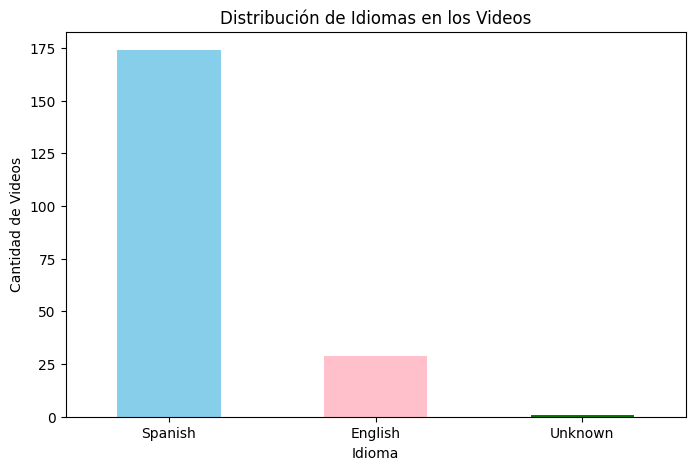

In [25]:
# NUEVA COLUMNA: detectar si el video es en inglés o en español con la librería langdetect

def detectar_idioma(texto):
    try:
        # Si el texto es NaN o vacío, devuelve 'Unknown'
        if pd.isna(texto) or texto == '':
            return 'Unknown'
        idioma = detect(str(texto))
        if idioma == 'es':
            return 'Spanish'
        elif idioma == 'en':
            return 'English'
        else:
            return 'Other'
    except:
        return 'Unknown'

df['original_video_language'] = df['transcription'].apply(detectar_idioma).astype('string')

print("\nDistribución de idiomas:")
print(df['original_video_language'].value_counts())

# Gráfica de barras:
plt.figure(figsize=(8, 5))
df['original_video_language'].value_counts().plot(kind='bar', color=['skyblue', 'pink', 'green'])
plt.title('Distribución de Idiomas en los Videos')
plt.xlabel('Idioma')
plt.ylabel('Cantidad de Videos')
plt.xticks(rotation=0)
plt.show()


In [26]:
# UNIFICACIÓN DE IDIOMA

def translate_text(text: str) -> str:
    try:
        if not text or str(text).strip() == '':
            return ''
        
        max_length = 4500
        if len(str(text)) <= max_length:
            return GoogleTranslator(source='auto', target='en').translate(str(text))
        chunks = [str(text)[i:i + max_length] for i in range(0, len(str(text)), max_length)]
        translated_chunks = []
        
        for chunk in chunks:
            translated = GoogleTranslator(source='auto', target='en').translate(chunk)
            translated_chunks.append(translated)
            time.sleep(1)
        return ' '.join(translated_chunks)
    except Exception as e:
        logging.error(f"Translation error for text: {e}")
        return text

def translate_with_retry(text: str, max_retries: int = 3) -> str:
    for attempt in range(max_retries):
        try:
            translated = translate_text(text)
            return translated
        except Exception as e:
            if attempt == max_retries - 1:
                logging.error(f"Failed to translate after {max_retries} attempts: {e}")
                return text
            time.sleep(2 ** attempt)

def translate_non_english_content(df: pd.DataFrame):
    total_rows = len(df)
    
    for index, row in df.iterrows():
        if str(row['original_video_language']).strip() != 'English':
            logging.info(f"Processing row {index + 1}/{total_rows}")
            
            # Traducir descripción
            if pd.notna(row['video_description']) and row['video_description'] != '':
                translated_desc = translate_with_retry(row['video_description'])
                df.at[index, 'video_description'] = translated_desc
                
            # Traducir transcripción (nombre correcto de la columna)
            if pd.notna(row['transcription']) and row['transcription'] != '':
                translated_trans = translate_with_retry(row['transcription'])
                df.at[index, 'transcription'] = translated_trans
            
            time.sleep(1)
        else:
            logging.info(f"Skipping row {index + 1}/{total_rows} (already in English)")

try:
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
    
    # Contar cuántas filas no están en inglés
    non_english_count = df[df['original_video_language'] != 'English'].shape[0]
    logging.info(f"Found {non_english_count} rows in non-English languages")
    
    if non_english_count > 0:
        logging.info("Starting translation process...")
        translate_non_english_content(df)
        logging.info("Translation process completed successfully")
    else:
        logging.info("No translation needed - all content is already in English")
    
except Exception as e:
    logging.error(f"An error occurred: {e}")

2025-03-01 00:50:21,587 - INFO - Found 175 rows in non-English languages
2025-03-01 00:50:21,589 - INFO - Starting translation process...
2025-03-01 00:50:21,593 - INFO - Processing row 1/204
2025-03-01 00:50:23,574 - INFO - Processing row 2/204
2025-03-01 00:50:25,395 - INFO - Processing row 3/204
2025-03-01 00:50:28,282 - INFO - Processing row 4/204
2025-03-01 00:50:30,676 - INFO - Processing row 5/204
2025-03-01 00:50:32,686 - INFO - Processing row 6/204
2025-03-01 00:50:34,934 - INFO - Processing row 7/204
2025-03-01 00:50:37,298 - INFO - Processing row 8/204
2025-03-01 00:50:39,544 - INFO - Processing row 9/204
2025-03-01 00:50:41,493 - INFO - Processing row 10/204
2025-03-01 00:50:43,643 - INFO - Processing row 11/204
2025-03-01 00:50:49,436 - INFO - Processing row 12/204
2025-03-01 00:50:51,727 - INFO - Processing row 13/204
2025-03-01 00:50:53,679 - INFO - Processing row 14/204
2025-03-01 00:50:56,443 - INFO - Processing row 15/204
2025-03-01 00:50:58,491 - INFO - Processing ro

In [27]:
df = df.rename(columns={'original_video_language': 'video_language'})

df['video_language'] = df['transcription'].apply(detectar_idioma)

total = len(df)
english_count = len(df[df['video_language'] == 'English'])
spanish_count = len(df[df['video_language'] == 'Spanish'])
other_count = len(df[df['video_language'] == 'Other']) 
unknown_count = len(df[df['video_language'] == 'Unknown'])

print("\nDistribución final de idiomas:")
print(f"English: {english_count/total*100:.2f}% ({english_count} videos)")
print(f"Spanish: {spanish_count/total*100:.2f}% ({spanish_count} videos)")
print(f"Other: {other_count/total*100:.2f}% ({other_count} videos)")
print(f"Unknown: {unknown_count/total*100:.2f}% ({unknown_count} videos)")


Distribución final de idiomas:
English: 99.51% (203 videos)
Spanish: 0.00% (0 videos)
Other: 0.00% (0 videos)
Unknown: 0.49% (1 videos)


In [28]:
df = df.drop('video_language', axis=1)

df.head(2)

,id_urlvideo,transcription,tiktok_username,followers_count,video_likes,video_description,publish_date,video_views,video_description_tags,description_emojis
0,https://www.tiktok.com/@aliciarev/video/728025...,What does my Skincare routine cost at night? I...,aliciarev,1400000,61200,How much does my Skincare routine cost at night?,2023-09-18,573000,,🧖♀🌙💸
1,https://www.tiktok.com/@cintia.makeuupp/video/...,"My daily makeup, the first thing I would do wo...",cintia.makeuupp,244100,46000,You have asked me a lot,2022-09-27,970100,"maquillajediario, pasoapaso, maquillaje, rutin...",💗🫶🏻


In [29]:
print("VALORES ÚNICOS DE ID")
print("--------------------")

try:
    # Estado inicial
    primera_columna_datos = df.iloc[:, 0]  
    total_filas_inicial = len(df)
    valores_unicos_inicial = len(primera_columna_datos.unique())
    print(f"Total de filas inicial: {total_filas_inicial}")
    print(f"Valores únicos inicial: {valores_unicos_inicial}")
    
    # Identificar duplicados antes de eliminar
    duplicados = df[df.iloc[:, 0].duplicated()]
    print(f"Número de filas duplicadas: {len(duplicados)}")
    
    if len(duplicados) > 0:
        print("\nValores que están duplicados:")
        duplicados_detalle = df.iloc[:, 0].value_counts()
        duplicados_detalle = duplicados_detalle[duplicados_detalle > 1]
        print(duplicados_detalle)
        # Eliminar duplicados - método alternativo
        print("\nEliminando duplicados...")
        indices_a_mantener = ~df.iloc[:, 0].duplicated(keep='last')
        df = df[indices_a_mantener]
    # Verificación final
    print(f"\nEstado final del DataFrame:")
    print(f"Número total de filas: {len(df)}")
    print(f"Número de valores únicos: {len(df.iloc[:, 0].unique())}")
    # Verificar que realmente se eliminaron los duplicados
    duplicados_finales = df[df.iloc[:, 0].duplicated()]
    if len(duplicados_finales) > 0:
        print("\n¡ADVERTENCIA! Aún quedan duplicados")
    else:
        print("\nSe han eliminado todos los duplicados correctamente")

except Exception as e:
    print(f"Error específico: {str(e)}")

VALORES ÚNICOS DE ID
--------------------
Total de filas inicial: 204
Valores únicos inicial: 192
Número de filas duplicadas: 12

Valores que están duplicados:
id_urlvideo
https://www.tiktok.com/@salmacadiz/video/7367379389044116768        3
https://www.tiktok.com/@sarahcatala/video/7423102991810579744       2
https://www.tiktok.com/@sarahcatala/video/7377113490030415136       2
https://www.tiktok.com/@katiagcolomer/video/7275833282850295073     2
https://www.tiktok.com/@mariagnz__/video/7378542844530724129        2
https://www.tiktok.com/@beatrizsnd/video/7424844434614897953        2
https://www.tiktok.com/@adriana_mfp/video/7309500535206464800       2
https://www.tiktok.com/@alba.puertas/video/7442700801601998113      2
https://www.tiktok.com/@jirethmerchan/video/7376031594684927264     2
https://www.tiktok.com/@maarinavallejo/video/7445656442897435936    2
https://www.tiktok.com/@aitanacandelas/video/7442343502060539169    2
Name: count, dtype: Int64

Eliminando duplicados...

Estad

In [30]:
# Verificar si quedan duplicados
duplicados_restantes = df[df.iloc[:, 0].duplicated()]
print(f"¿Quedan duplicados? {len(duplicados_restantes) > 0}")

¿Quedan duplicados? False



📊 ANÁLISIS DE VARIABLES NUMÉRICAS
----------------------------------------


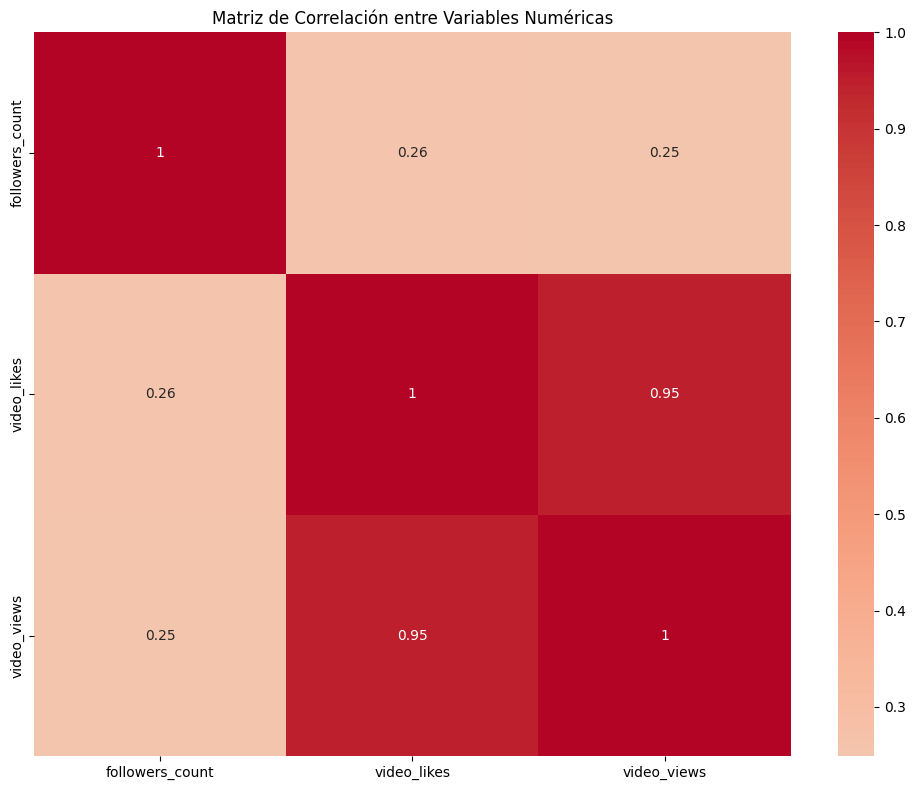


Analizando: followers_count
--------------------


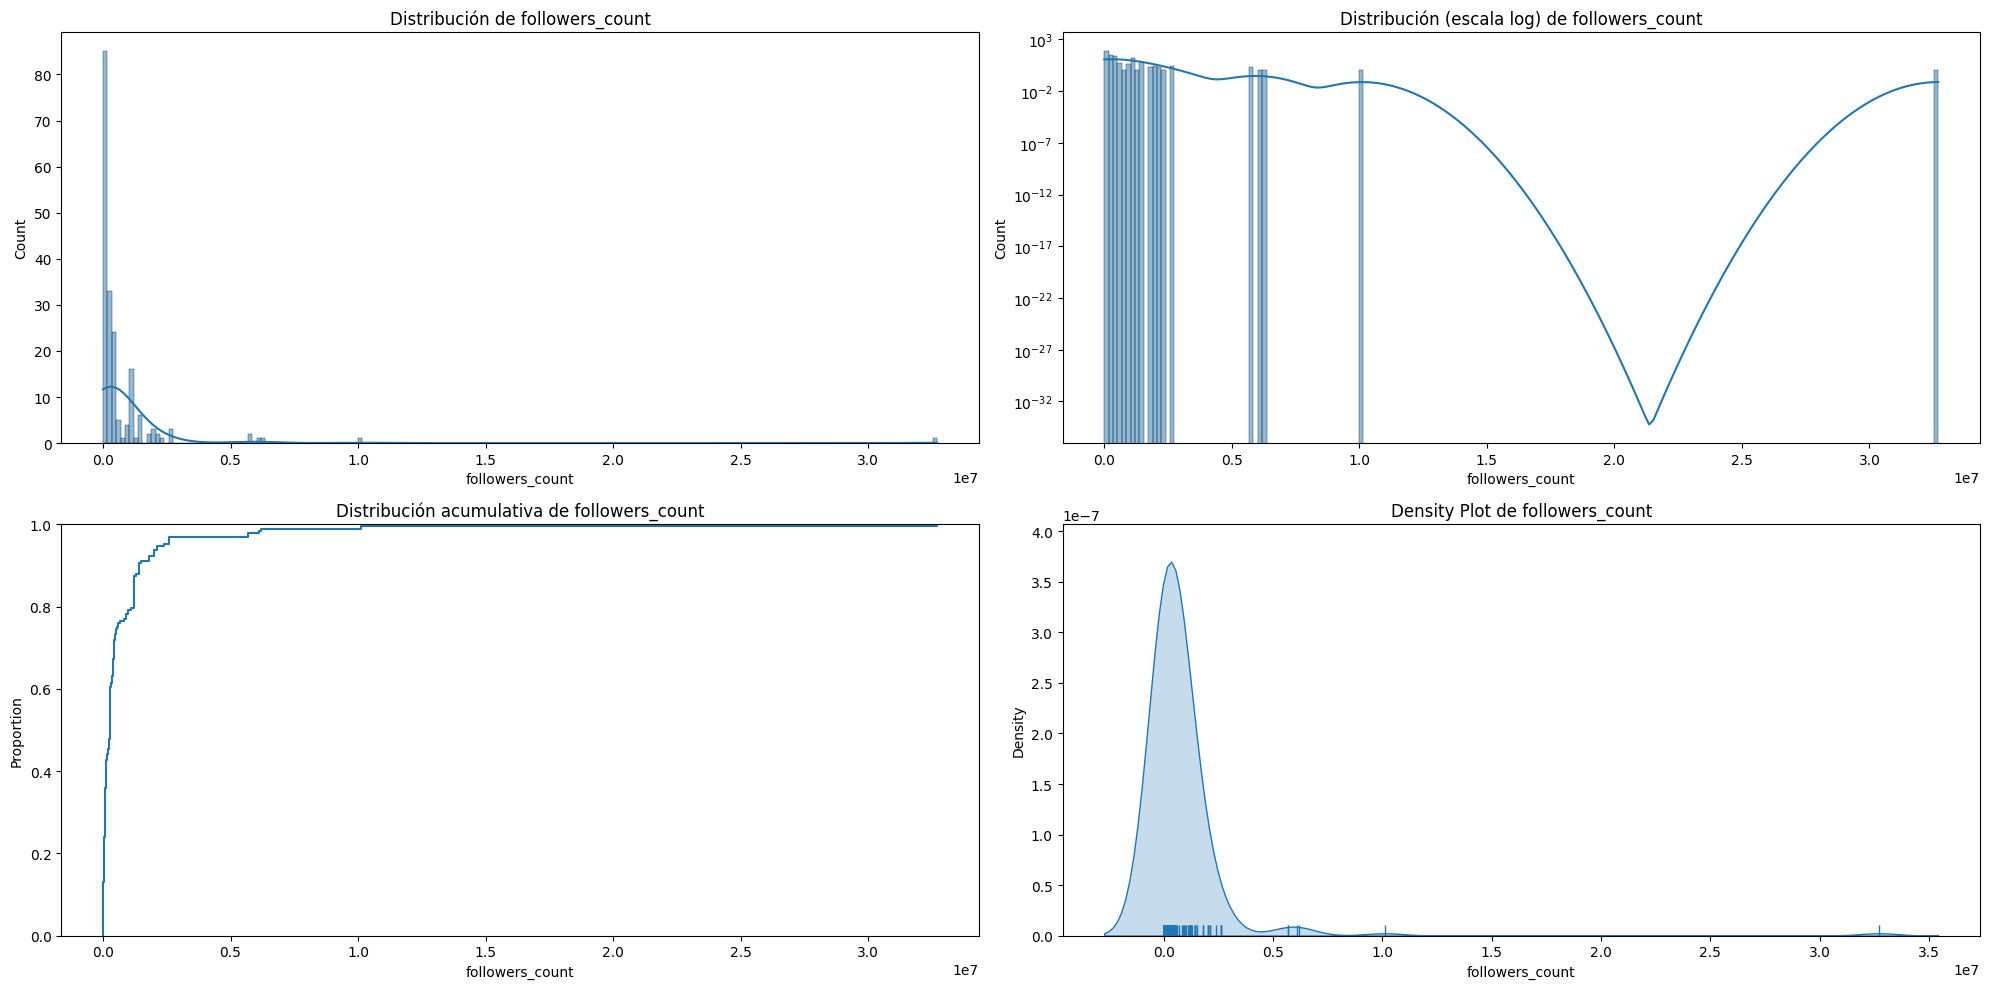


Estadísticas descriptivas:
count    1.920000e+02
mean     7.847726e+05
std      2.605464e+06
min      7.200000e+01
25%      6.377500e+04
50%      2.714000e+05
75%      5.616000e+05
max      3.270000e+07
Name: followers_count, dtype: float64

Métricas adicionales:
Asimetría (Skewness): 10.13
Curtosis: 119.81

Número de outliers detectados: 23

Analizando: video_likes
--------------------


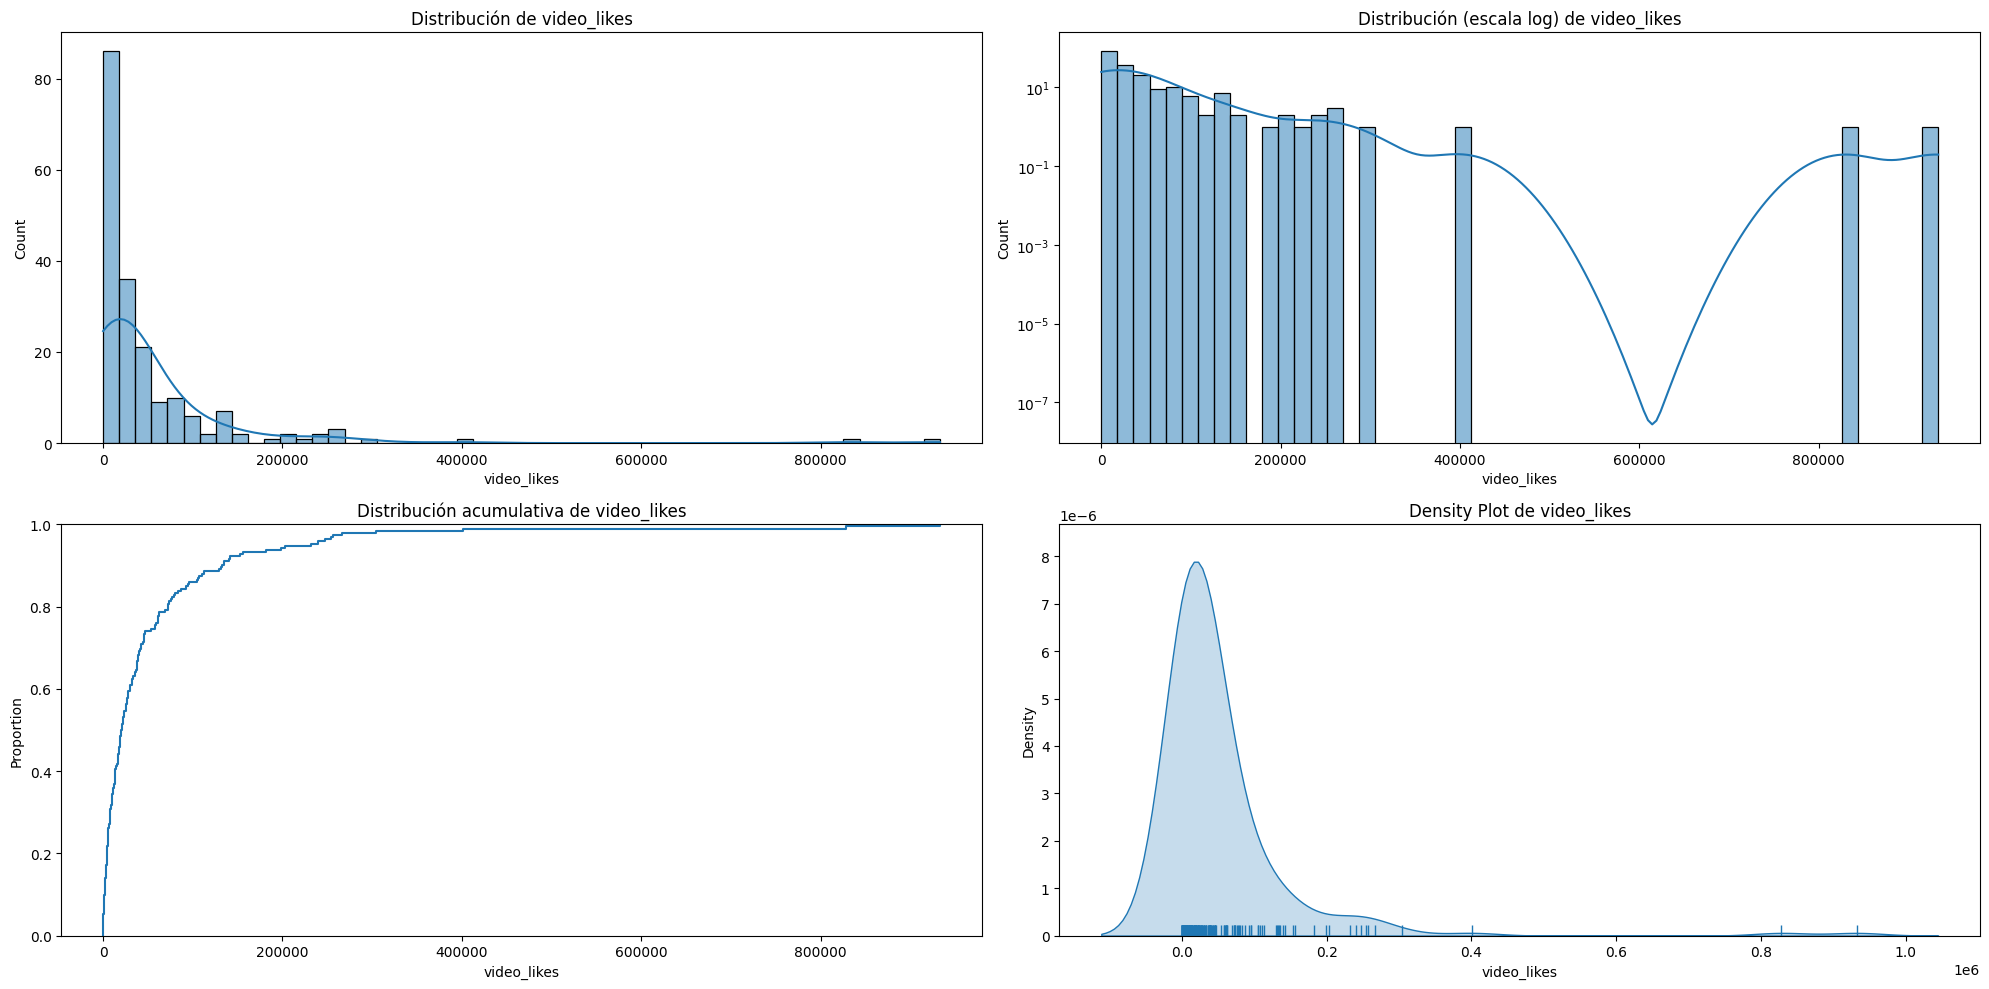


Estadísticas descriptivas:
count       192.000000
mean      53452.244792
std      106564.251283
min         111.000000
25%        5671.000000
50%       20350.000000
75%       58025.000000
max      933200.000000
Name: video_likes, dtype: float64

Métricas adicionales:
Asimetría (Skewness): 5.48
Curtosis: 38.38

Número de outliers detectados: 17

Analizando: video_views
--------------------


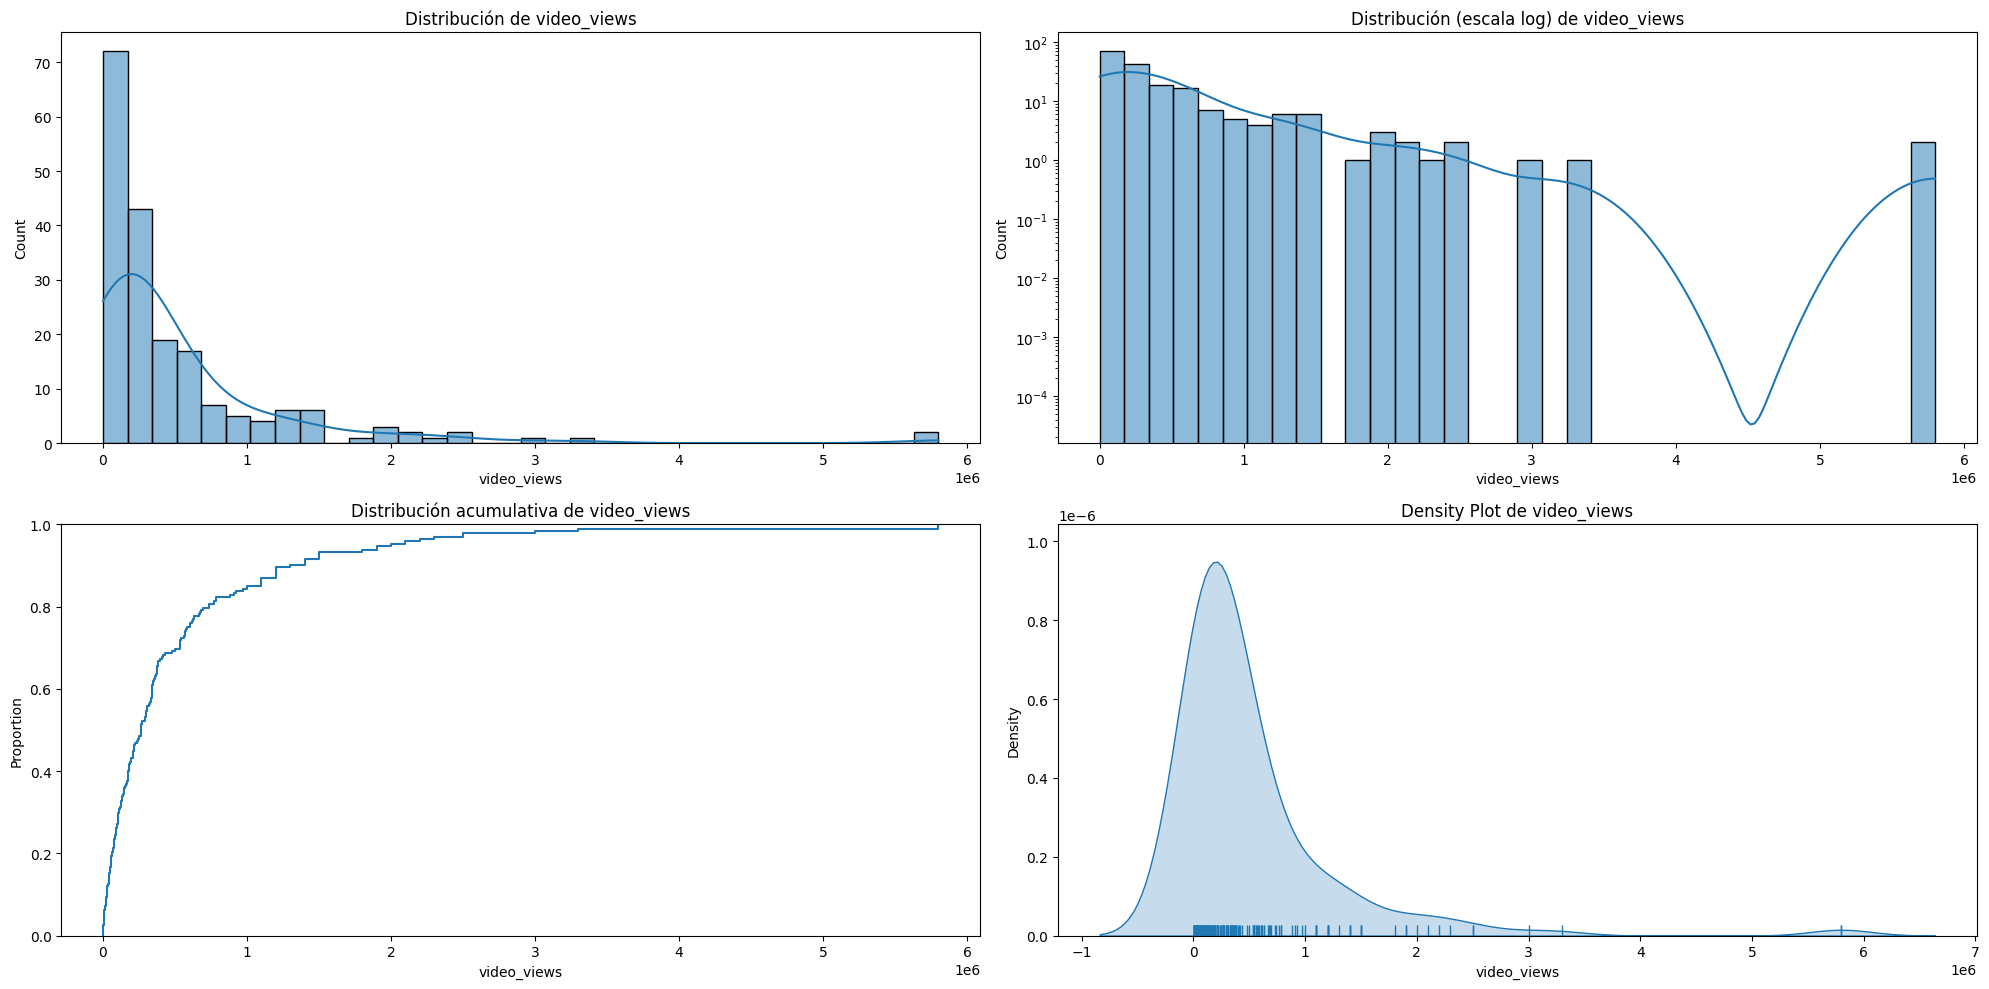


Estadísticas descriptivas:
count    1.920000e+02
mean     5.230917e+05
std      8.022305e+05
min      1.542000e+03
25%      9.370000e+04
50%      2.656500e+05
75%      5.902750e+05
max      5.800000e+06
Name: video_views, dtype: float64

Métricas adicionales:
Asimetría (Skewness): 3.80
Curtosis: 19.48

Número de outliers detectados: 19

📅 ANÁLISIS DE VARIABLES TEMPORALES
----------------------------------------

Analizando: publish_date
--------------------

Rango temporal:
Fecha más antigua: 2020-09-03 00:00:00
Fecha más reciente: 2025-02-28 00:00:00
Rango total en días: 1639


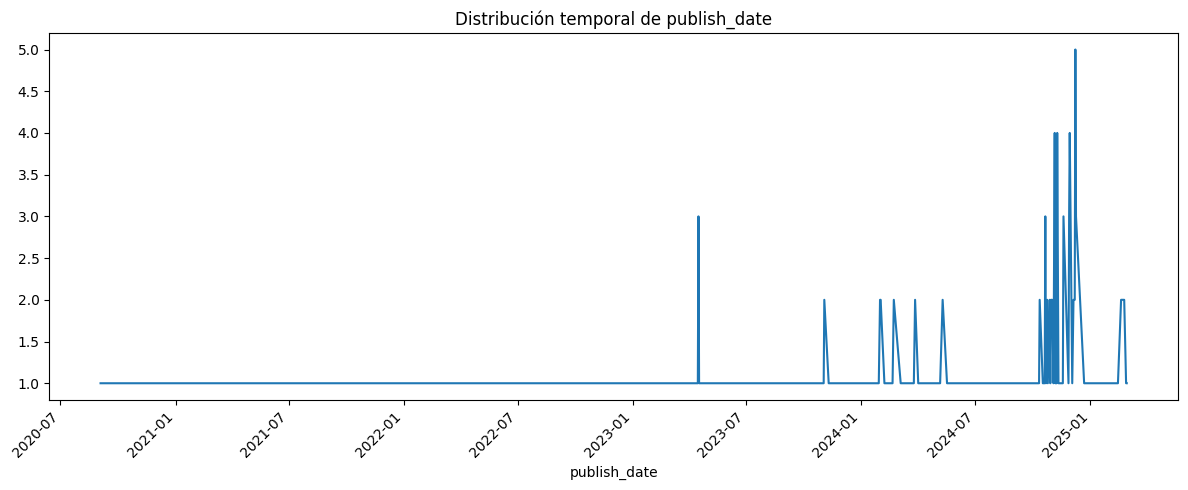


📝 ANÁLISIS DE VARIABLES DE TEXTO
----------------------------------------

Analizando: id_urlvideo
--------------------
Número de valores únicos: 192

Estadísticas de longitud del texto:
Longitud media: 61.71
Longitud mínima: 56
Longitud máxima: 84

Analizando: transcription
--------------------
Número de valores únicos: 191

Estadísticas de longitud del texto:
Longitud media: 2856.55
Longitud mínima: 43
Longitud máxima: 9605


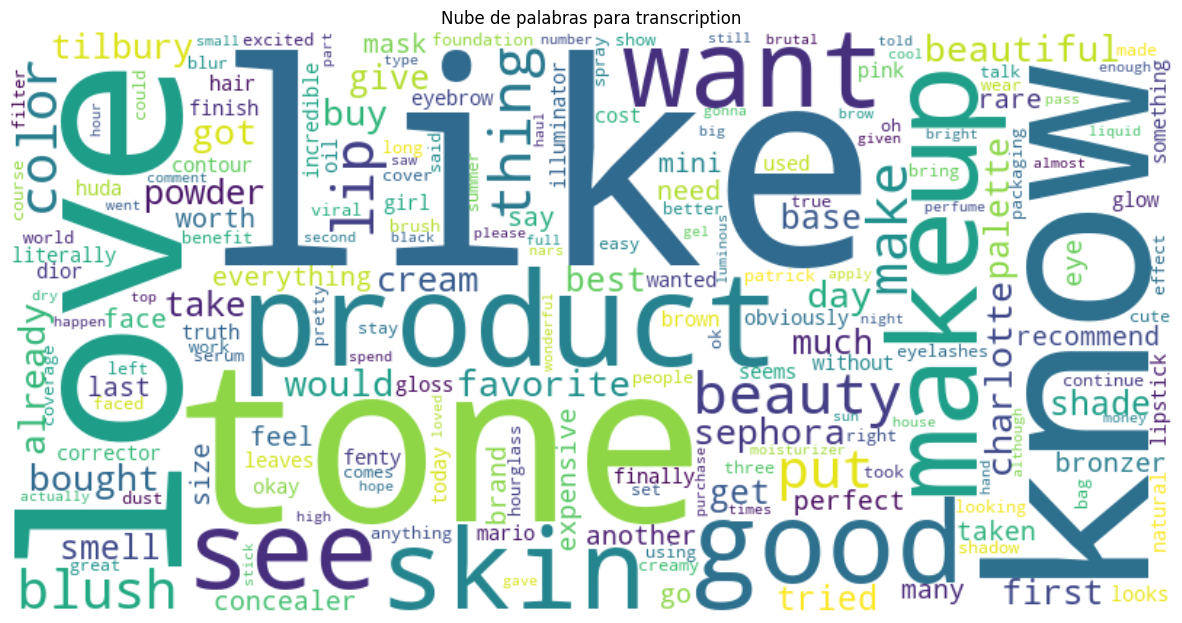


Top 20 palabras más frecuentes:
like: 907
know: 504
love: 499
tone: 427
makeup: 376
good: 344
skin: 326
want: 315
see: 313
beauty: 288
blush: 266
put: 264
sephora: 253
buy: 242
got: 235
bought: 233
make: 229
beautiful: 229
products: 227
would: 226

Analizando: tiktok_username
--------------------
Número de valores únicos: 132

Estadísticas de longitud del texto:
Longitud media: 11.59
Longitud mínima: 6
Longitud máxima: 20

Analizando: video_description
--------------------
Número de valores únicos: 188

Estadísticas de longitud del texto:
Longitud media: 60.59
Longitud mínima: 0
Longitud máxima: 510


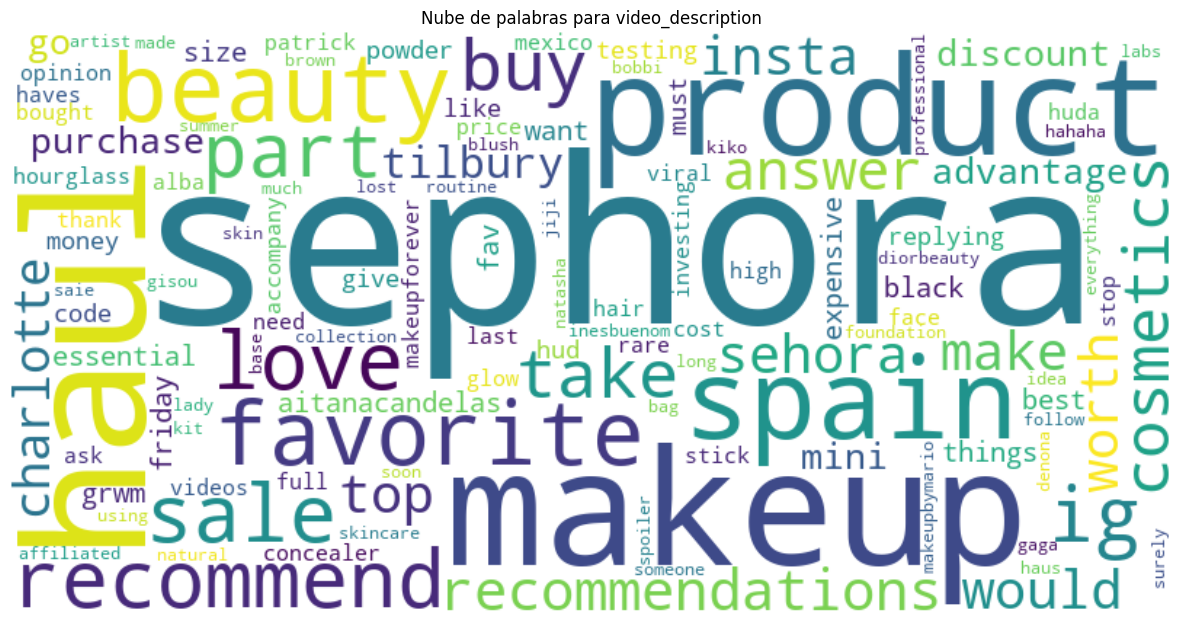


Top 20 palabras más frecuentes:
sephora: 107
haul: 48
makeup: 46
products: 36
spain: 23
beauty: 16
recommend: 13
love: 12
sale: 12
part: 11
buy: 10
favorites: 8
cosmetics: 8
recommendations: 8
answer: 8
would: 7
insta: 7
top: 7
worth: 7
sehora: 7

Analizando: video_description_tags
--------------------
Número de valores únicos: 165

Estadísticas de longitud del texto:
Longitud media: 91.45
Longitud mínima: 0
Longitud máxima: 349


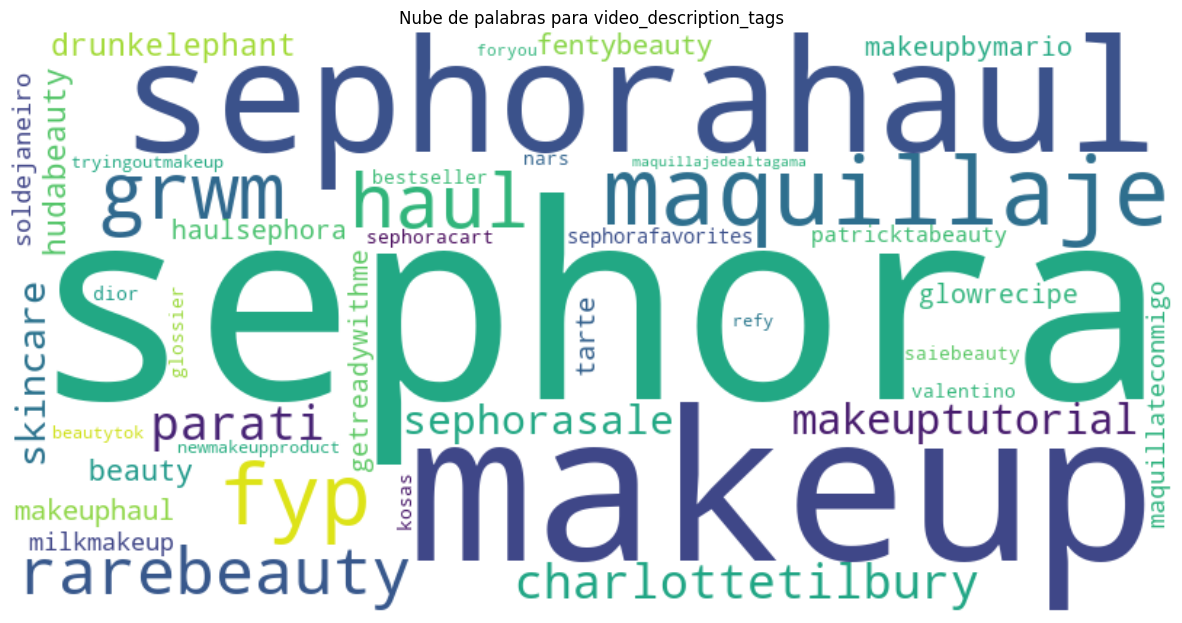


Top 20 palabras más frecuentes:
sephora: 93
makeup: 90
sephorahaul: 55
maquillaje: 42
fyp: 33
grwm: 29
rarebeauty: 23
haul: 22
charlottetilbury: 21
parati: 21
makeuptutorial: 19
sephorasale: 19
skincare: 18
drunkelephant: 16
hudabeauty: 16
beauty: 15
fentybeauty: 14
tarte: 14
makeuphaul: 14
glowrecipe: 13

Analizando: description_emojis
--------------------
Número de valores únicos: 122

Estadísticas de longitud del texto:
Longitud media: 1.86
Longitud mínima: 0
Longitud máxima: 11

Emojis únicos encontrados:
<StringArray>
[                '🧖♀🌙💸',                  '💗🫶🏻',                    '🫠',
                   '💗✨',                     '',                    '🤍',
                    '💖',                   '😍💓',         '🎀\U0001fa77🤍',
                '🫣✨❌🥹💗',
 ...
                  '🫣❤🩹',                  '💘💓🥹',                  '🌊🐚✨',
                '😊🙃🥴👀👇',                   '😙😙',                  '❤🔥✨',
                  '😮💨🫢', '\U0001fa77\U0001fa77',                  '⭐🤳🏽',
  

In [31]:
# Análisis Exploratorio-Descriptivo: 

def analizar_dataset(df):
    '''Analiza automáticamente todas las columnas del DataFrame según su tipo de dato.'''

    # STOPWORDS: español e inglés
    try:
        nltk.download('stopwords', quiet=True)
        stop_words_es = set(stopwords.words('spanish'))
        stop_words_en = set(stopwords.words('english'))

        # Palabras extra que quiero que elimine: 
        palabras_personalizadas = {
            'one', 'going', 'dont', 'really', 'also', 'super', 'use', 'little', 'well', 'ive', 'look', 'think', 'im', 'bit', 'seem', 'fisrt', 
            'okey', 'move', 'year', 'since', 'even', 'theres', 'quite', 'guy', 'time', 'come', 'cant', 'friend', 'every', 'dark', 'try', 'life', 'video', 
            'thats', 'ill', 'leave', 'ever', 'ones', 'doesnt', 'let', 'light', 'lot', 'start', 'never', 'tell', 'euro', 'nothing', 'always','end', 'called', 
            'theyre', 'way', 'circle', 'ta', 'fact', 'guys', 'didnt', 'next', 'seen', 'lets', 'new', 'years', 'euros', 'two', 'yes'}
        stop_words = stop_words_es.union(stop_words_en).union(palabras_personalizadas)
    except:
        print("Error descargando stopwords, usando lista básica")
        stop_words = {'de', 'la', 'el', 'en', 'y', 'a', 'que', 'the', 'of', 'to', 'and'}
    
    tipos_columnas = df.dtypes
    columnas_numericas = df.select_dtypes(include=['int64', 'float64']).columns
    columnas_fecha = df.select_dtypes(include=['datetime64']).columns
    columnas_texto = df.select_dtypes(include=['object', 'string']).columns
    
    # ANÁLISIS: Columnas Numéricas: 
    if len(columnas_numericas) > 0:
        print("\n📊 ANÁLISIS DE VARIABLES NUMÉRICAS")
        print("-"*40)
        
        # Matriz de Correlación para más de una variable numérica:
        if len(columnas_numericas) > 1:
            plt.figure(figsize=(10, 8))
            sns.heatmap(df[columnas_numericas].corr(), annot=True, cmap='coolwarm', center=0)
            plt.title('Matriz de Correlación entre Variables Numéricas')
            plt.tight_layout()
            plt.show()
        
        for columna in columnas_numericas:
            try:
                print(f"\nAnalizando: {columna}")
                print("-"*20)
                
                # Crear una figura con 4 subplots
                fig = plt.figure(figsize=(20, 10))
                
                # 1. Histograma con escala normal
                ax1 = plt.subplot(221)
                sns.histplot(data=df, x=columna, kde=True, ax=ax1)
                ax1.set_title(f'Distribución de {columna}')
                
                # 2. Histograma con escala logarítmica
                ax2 = plt.subplot(222)
                sns.histplot(data=df, x=columna, kde=True, ax=ax2)
                ax2.set_yscale('log')
                ax2.set_title(f'Distribución (escala log) de {columna}')
                
                # 3. ECDF (Empirical Cumulative Distribution)
                ax3 = plt.subplot(223)
                sns.ecdfplot(data=df, x=columna, ax=ax3)
                ax3.set_title(f'Distribución acumulativa de {columna}')
                
                # 4. Density Plot con rug plot
                ax4 = plt.subplot(224)
                sns.kdeplot(data=df[columna], fill=True, ax=ax4)
                sns.rugplot(data=df[columna], ax=ax4)
                ax4.set_title(f'Density Plot de {columna}')
                
                plt.tight_layout()
                plt.show()
                
                # Estadísticas descriptivas
                print("\nEstadísticas descriptivas:")
                stats = df[columna].describe()
                print(stats)
                
                # Métricas adicionales
                print("\nMétricas adicionales:")
                print(f"Asimetría (Skewness): {df[columna].skew():.2f}")
                print(f"Curtosis: {df[columna].kurtosis():.2f}")
                
                # Detectar outliers
                Q1 = stats['25%']
                Q3 = stats['75%']
                IQR = Q3 - Q1
                outliers = df[(df[columna] < (Q1 - 1.5 * IQR)) | (df[columna] > (Q3 + 1.5 * IQR))][columna]
                print(f"\nNúmero de outliers detectados: {len(outliers)}")
                
            except Exception as e:
                print(f"Error al analizar {columna}: {e}")
    
    # ANÁLISIS: Columnas Temporales: 
    if len(columnas_fecha) > 0:
        print("\n📅 ANÁLISIS DE VARIABLES TEMPORALES")
        print("-"*40)
        for columna in columnas_fecha:
            try:
                print(f"\nAnalizando: {columna}")
                print("-"*20)
                
                # Estadísticas temporales
                print("\nRango temporal:")
                print(f"Fecha más antigua: {df[columna].min()}")
                print(f"Fecha más reciente: {df[columna].max()}")
                print(f"Rango total en días: {(df[columna].max() - df[columna].min()).days}")
                
                # Distribución temporal
                plt.figure(figsize=(12, 5))
                df[columna].value_counts().sort_index().plot(kind='line')
                plt.title(f'Distribución temporal de {columna}')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Error al analizar {columna}: {e}")
    
    # ANÁLISIS: Columnas de Texto: 
    if len(columnas_texto) > 0:
        print("\n📝 ANÁLISIS DE VARIABLES DE TEXTO")
        print("-"*40)
        for columna in columnas_texto:
            try:
                print(f"\nAnalizando: {columna}")
                print("-"*20)
                
                # Estadísticas básicas
                n_unique = df[columna].nunique()
                print(f"Número de valores únicos: {n_unique}")
                
                # Si hay menos de 20 valores únicos, mostrar distribución
                if n_unique < 20:
                    plt.figure(figsize=(10, 5))
                    df[columna].value_counts().plot(kind='bar')
                    plt.title(f'Distribución de {columna}')
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.show()
                
                longitudes = df[columna].str.len()
                print("\nEstadísticas de longitud del texto:")
                print(f"Longitud media: {longitudes.mean():.2f}")
                print(f"Longitud mínima: {longitudes.min()}")
                print(f"Longitud máxima: {longitudes.max()}")
                
                # Columnas Username: hacer un ranking de frecuencia de aparición (influencers que más videos tienen)
                if columna == 'username':
                    value_counts = df[columna].value_counts()
                    print("\nTop 20 usernames más frecuentes:")
                    print(value_counts.head(20))
                
                # Emojis de la descripción: más basico (no muy relevante de momento)
                elif columna == 'description_emojis':
                    print("\nEmojis únicos encontrados:")
                    print(df[columna].unique())
                
                # Para las otras columnas de texto con más texto, hacer nubes de palabras: 
                elif columna in ['video_description', 'video_description_tags', 'transcription']:
                    texto_completo = ' '.join(df[columna].dropna().astype(str))
                    # Limpieza básica del texto:
                    texto_completo = texto_completo.lower()
                    texto_completo = re.sub(r'http\S+|www.\S+', '', texto_completo)
                    texto_completo = re.sub(r'[^\w\s]', '', texto_completo)
                    texto_completo = re.sub(r'\d+', '', texto_completo)

                    # NUBE con librería wordcloud: 
                    wordcloud = WordCloud(
                        width=800, 
                        height=400,
                        background_color='white',
                        stopwords=stop_words,
                        min_font_size=10,
                        collocations=False  # Evita que las palabras se repitan
                    ).generate(texto_completo)
                    
                    plt.figure(figsize=(15, 8))
                    plt.imshow(wordcloud, interpolation='bilinear')
                    plt.axis('off')
                    plt.title(f'Nube de palabras para {columna}')
                    plt.show()
                    
                    # Top palabras más frecuentes
                    words = [word for word in texto_completo.split() 
                            if word not in stop_words and len(word) > 2]
                    word_freq = Counter(words)
                    
                    print("\nTop 20 palabras más frecuentes:")
                    for word, freq in word_freq.most_common(20):
                        print(f"{word}: {freq}")
                
            except Exception as e:
                print(f"Error al analizar {columna}: {e}")

analizar_dataset(df)

In [32]:
nuevo_archivo = 'data/clean_data/url_data_cleaned.xlsx'
# Asegurarse de que el directorio clean_data existe
if not os.path.exists('data/clean_data'):
   os.makedirs('data/clean_data')
# Guardar
df.to_excel(nuevo_archivo, index=False)
print(f"Archivo guardado exitosamente en: {nuevo_archivo}")

Archivo guardado exitosamente en: data/clean_data/url_data_cleaned.xlsx
